## Gathering Dependencies

_Importing Required Libraries_

In [9]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [10]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array
from tensorflow.keras.callbacks import EarlyStopping

## Loading Datasets

_SAN JUAN_

In [11]:
data = pd.read_csv("datasets/sanjuan.csv")
training_set = data.iloc[:, 3]
print(training_set)

0        4
1        5
2        4
3        3
4        6
        ..
1191    56
1192    46
1193    52
1194    34
1195    25
Name: Cases, Length: 1196, dtype: int64


## Preprocessing the Data

In [12]:
# Multivariate data preparation
from numpy import array

# split a Multivariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, features):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_out = 13
n_steps_in = 10
n_features = 1

# split into samples
X, y = split_sequence(training_set, n_steps_in, n_steps_out, n_features)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[ 4  5  4  3  6  2  4  5 10  6] [ 8  2  6 17 23 13 21 28 24 20 40 27 42]
[ 5  4  3  6  2  4  5 10  6  8] [ 2  6 17 23 13 21 28 24 20 40 27 42 33]
[ 4  3  6  2  4  5 10  6  8  2] [ 6 17 23 13 21 28 24 20 40 27 42 33 43]
[ 3  6  2  4  5 10  6  8  2  6] [17 23 13 21 28 24 20 40 27 42 33 43 37]
[ 6  2  4  5 10  6  8  2  6 17] [23 13 21 28 24 20 40 27 42 33 43 37 57]
[ 2  4  5 10  6  8  2  6 17 23] [13 21 28 24 20 40 27 42 33 43 37 57 71]
[ 4  5 10  6  8  2  6 17 23 13] [21 28 24 20 40 27 42 33 43 37 57 71 44]
[ 5 10  6  8  2  6 17 23 13 21] [28 24 20 40 27 42 33 43 37 57 71 44 56]
[10  6  8  2  6 17 23 13 21 28] [24 20 40 27 42 33 43 37 57 71 44 56 53]
[ 6  8  2  6 17 23 13 21 28 24] [20 40 27 42 33 43 37 57 71 44 56 53 52]
[ 8  2  6 17 23 13 21 28 24 20] [40 27 42 33 43 37 57 71 44 56 53 52 47]
[ 2  6 17 23 13 21 28 24 20 40] [27 42 33 43 37 57 71 44 56 53 52 47 26]
[ 6 17 23 13 21 28 24 20 40 27] [42 33 43 37 57 71 44 56 53 52 47 26 27]
[17 23 13 21 28 24 20 40 27 42] [33 43 37 57 71 44 

## Train and Test Split

In [13]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(X)
dataY = np.array(y)
trainX = np.array(X[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(X[train_size:len(X)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(939, 1, 10) (939, 13) (235, 1, 10) (235, 13)


## Model

In [14]:
# split a Multivariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, features):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_out = 13
n_steps_in = 10
n_features = 1

# split into samples
X, y = split_sequence(training_set, n_steps_in, n_steps_out, n_features)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
test_days = 227
trainX, trainY = X[:-test_days], y[:-test_days]
testX, testY = X[-test_days:], y[-test_days:]

custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=1, 
    min_delta=10, 
    mode='min'
)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(13))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False, callbacks=[custom_early_stopping])

Epoch 1/500
15/15 [==============================] - 3s 57ms/step - loss: 3760.6401 - val_loss: 7673.3911
Epoch 2/500
15/15 [==============================] - 0s 11ms/step - loss: 3736.5435 - val_loss: 7637.4321
Epoch 3/500
15/15 [==============================] - 0s 11ms/step - loss: 3709.0942 - val_loss: 7588.9229
Epoch 4/500
15/15 [==============================] - 0s 13ms/step - loss: 3669.0139 - val_loss: 7510.2168
Epoch 5/500
15/15 [==============================] - 0s 9ms/step - loss: 3608.9604 - val_loss: 7378.6509
Epoch 6/500
15/15 [==============================] - 0s 7ms/step - loss: 3532.2261 - val_loss: 7231.9414
Epoch 7/500
15/15 [==============================] - 0s 7ms/step - loss: 3460.5864 - val_loss: 7087.3345
Epoch 8/500
15/15 [==============================] - 0s 7ms/step - loss: 3397.4126 - val_loss: 6959.8403
Epoch 9/500
15/15 [==============================] - 0s 9ms/step - loss: 3344.3240 - val_loss: 6856.1729
Epoch 10/500
15/15 [==============================]

## Metrics

In [15]:
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]*10))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

8/8 [==============================] - 0s 935us/step
(227, 13)
(227, 10)
Test RMSE: 64.014
Test MAE: 38.457


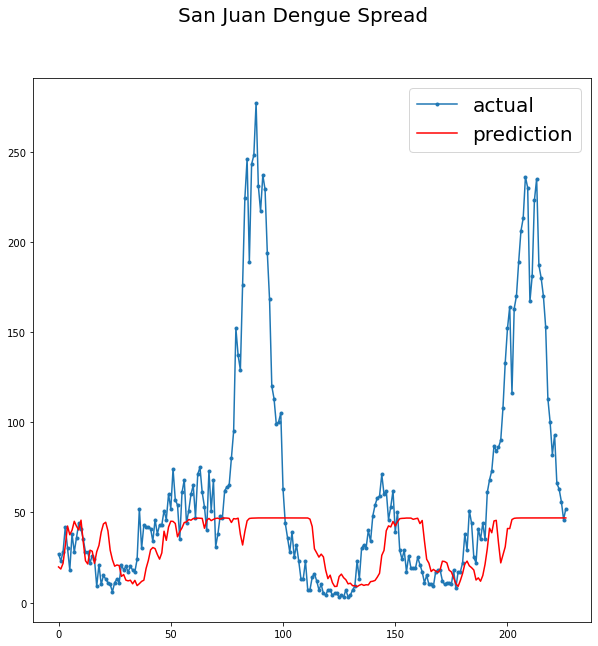

In [16]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('San Juan Dengue Spread', fontsize=20)
plt.legend(fontsize=20)
plt.show()